In [32]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

<h3>Importing Dataframe</h3>

In [36]:
parse_dates = ['fecha_ingreso_hosp']
df = pd.read_csv('data.csv',parse_dates=parse_dates,dayfirst=True)

<center><h1> 1: Data Processing</h1></center>

<h3>Data cleaning</h3>

In [37]:
df = df.sort_values(by = 'fecha_ingreso_hosp', ascending= True)
df = df[(df['fecha_ingreso_hosp'] >= '2021-05-01') & (df['cdc_positividad'] == 1)] 
#Droping Unnecessary Features (Dates,Geo,ID's)
lst_drop = [
 'id_persona','fecha_ingreso_uci', 
 'fecha_ingreso_ucin','fecha_ingreso_ucin', 
 'fecha_segumiento_hosp_ultimo','fecha_ingreso_hosp',
 'evolucion_hosp_ultimo','cdc_fecha_fallecido_covid',
 'fecha_dosis1', 'fecha_dosis2', 'fecha_dosis3',
 'eess_renaes','eess_diresa','eess_red','eess_red',
 'eess_nombre','eess_red', 'ubigeo_inei_domicilio',
 'dep_domicilio','prov_domicilio', 'dist_domicilio','id_eess'] 
df = df.drop(columns=lst_drop)
#Drop Missing Values
df = df[(df['edad'].notna()) & (df['sexo'].notna()) & (df['con_oxigeno'].notna()) & (df['con_ventilacion'].notna())] 
#Age Group Segmentation
df.loc[df['edad'].between(0,5), 'age_group'] = 'Edad 0-5'
df.loc[df['edad'].between(6,11), 'age_group'] = 'Edad 6-11'
df.loc[df['edad'].between(12,18), 'age_group'] = 'Edad 12-18'
df.loc[df['edad'].between(19,24), 'age_group'] = 'Edad 19-24'
df.loc[df['edad'].between(25,39), 'age_group'] = 'Edad 25-39'
df.loc[df['edad'].between(40,49), 'age_group'] = 'Edad 40-49'
df.loc[df['edad'].between(50,64), 'age_group'] = 'Edad 50-64'
df.loc[df['edad'].between(65,75), 'age_group'] = 'Edad 65-75'
df.loc[df['edad']>75, 'age_group'] = 'Edad 75+'
df = df.drop(columns=['edad']) 

<h3>Features Information</h3>

In [38]:
#Conversión a enteros 
convert_dict = {'con_oxigeno': int,
                'con_ventilacion': int,
                'flag_vacuna' : int
               }
df_1 = df.astype(convert_dict)
#Set categories to missing values 
df_1['fabricante_dosis1'] = df['fabricante_dosis1'].replace(np.nan, 'NULL')
df_1['fabricante_dosis2'] = df['fabricante_dosis2'].replace(np.nan, 'NULL')
df_1['fabricante_dosis3'] = df['fabricante_dosis3'].replace(np.nan, 'NULL')
df_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20556 entries, 95815 to 100768
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sexo                 20556 non-null  object
 1   flag_uci             20556 non-null  int64 
 2   con_oxigeno          20556 non-null  int32 
 3   con_ventilacion      20556 non-null  int32 
 4   flag_vacuna          20556 non-null  int32 
 5   fabricante_dosis1    20556 non-null  object
 6   fabricante_dosis2    20556 non-null  object
 7   fabricante_dosis3    20556 non-null  object
 8   cdc_positividad      20556 non-null  int64 
 9   cdc_fallecido_covid  20556 non-null  int64 
 10  age_group            20556 non-null  object
dtypes: int32(3), int64(3), object(5)
memory usage: 1.6+ MB


In [39]:
tabl = df_1.pivot_table(index = 'flag_vacuna', columns = 'cdc_fallecido_covid',values = 'cdc_positividad', aggfunc='count') 
print(tabl)

cdc_fallecido_covid      0     1
flag_vacuna                     
0                     1437  3242
1                      662   574
2                     3016   928
3                    10483   214


In [40]:
lst = ['fabricante_dosis1','fabricante_dosis2','fabricante_dosis3']
for value in lst:
    table = df_1.pivot_table(index = value, columns = 'cdc_fallecido_covid',values = 'cdc_positividad', aggfunc='count',fill_value=0)
    table[' % Fallecidos'] = round((table[1]/(table[0]+table[1]))*100,2)
    table = table.drop(index=['NULL'])
    print(table)
    print('--------------')


cdc_fallecido_covid     0     1   % Fallecidos
fabricante_dosis1                             
ASTRAZENECA          1245   236          15.94
PFIZER               6778  1214          15.19
SINOPHARM            6138   266           4.15
--------------
cdc_fallecido_covid     0    1   % Fallecidos
fabricante_dosis2                            
ASTRAZENECA          1145  137          10.69
PFIZER               6543  820          11.14
SINOPHARM            5821  186           3.10
--------------
cdc_fallecido_covid     0    1   % Fallecidos
fabricante_dosis3                            
ASTRAZENECA          1979    5           0.25
MODERNA               131    0           0.00
PFIZER               8427  210           2.43
SINOPHARM               1    0           0.00
--------------


<h3>Dummy Variables</h3>

In [41]:
#Dummy Variable Sex
df_1["sexo"] = np.where(df_1["sexo"] == "F", 0, 1)
#Others
cat_vars=['flag_vacuna','fabricante_dosis1','fabricante_dosis2','fabricante_dosis3','age_group']
for var in cat_vars:
    cat_list ='var'+ '_'+var
    cat_list = pd.get_dummies(df_1[var], prefix=var)
    data1=df_1.join(cat_list)
    df_1=data1

cat_vars=['flag_vacuna','fabricante_dosis1','fabricante_dosis2','fabricante_dosis3','age_group']
data_vars=df_1.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=df_1[to_keep]
lst = ['fabricante_dosis1_NULL','fabricante_dosis2_NULL','fabricante_dosis3_NULL']
data_final = data_final.drop(columns = lst)
data_final.columns.values

array(['sexo', 'flag_uci', 'con_oxigeno', 'con_ventilacion',
       'cdc_positividad', 'cdc_fallecido_covid', 'flag_vacuna_0',
       'flag_vacuna_1', 'flag_vacuna_2', 'flag_vacuna_3',
       'fabricante_dosis1_ASTRAZENECA', 'fabricante_dosis1_PFIZER',
       'fabricante_dosis1_SINOPHARM', 'fabricante_dosis2_ASTRAZENECA',
       'fabricante_dosis2_PFIZER', 'fabricante_dosis2_SINOPHARM',
       'fabricante_dosis3_ASTRAZENECA', 'fabricante_dosis3_MODERNA',
       'fabricante_dosis3_PFIZER', 'fabricante_dosis3_SINOPHARM',
       'age_group_Edad 0-5', 'age_group_Edad 12-18',
       'age_group_Edad 19-24', 'age_group_Edad 25-39',
       'age_group_Edad 40-49', 'age_group_Edad 50-64',
       'age_group_Edad 6-11', 'age_group_Edad 65-75',
       'age_group_Edad 75+'], dtype=object)

<center><h1>2: Feature Selection</h1></center>

<h3>Synthetic Minority Oversampling Technique</h3>

In [42]:
X = data_final.loc[:, data_final.columns != 'cdc_fallecido_covid']
y = data_final.loc[:, data_final.columns == 'cdc_fallecido_covid']
print(data_final['cdc_fallecido_covid'].value_counts())

0    15598
1     4958
Name: cdc_fallecido_covid, dtype: int64


In [43]:
from sklearn import preprocessing
os = SMOTE(random_state=0)
#Entrenamiento de datos para conseguir el Oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y= os.fit_resample(X_train, y_train)
#Creación del data frame nuevo
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['cdc_fallecido_covid'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no diseases by covid-19",len(os_data_y[os_data_y['cdc_fallecido_covid']==0]))
print("Number of diseases by covid-19",len(os_data_y[os_data_y['cdc_fallecido_covid']==1]))
print("Proportion of no diseases by covid-19 in oversampled data is ",len(os_data_y[os_data_y['cdc_fallecido_covid']==0])/len(os_data_X))
print("Proportion of diseases by covid-19 in oversampled data is ",len(os_data_y[os_data_y['cdc_fallecido_covid']==1])/len(os_data_X))

length of oversampled data is  21738
Number of no diseases by covid-19 10869
Number of diseases by covid-19 10869
Proportion of no diseases by covid-19 in oversampled data is  0.5
Proportion of diseases by covid-19 in oversampled data is  0.5


<h3>Recursive Feature Elimination</h3>

In [50]:
data_final_vars=data_final.columns.values.tolist()
y=['cdc_fallecido_covid']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select = 18)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
result = np.where(rfe.ranking_ == 1)
lst = []
for i in range(0,18): lst.append(result[0][i])
lst_1 = []
for i in lst: lst_1.append(X[i])  
print(lst_1)

c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

['con_oxigeno', 'con_ventilacion', 'fabricante_dosis1_ASTRAZENECA', 'fabricante_dosis1_PFIZER', 'fabricante_dosis1_SINOPHARM', 'fabricante_dosis2_PFIZER', 'fabricante_dosis2_SINOPHARM', 'fabricante_dosis3_ASTRAZENECA', 'fabricante_dosis3_MODERNA', 'fabricante_dosis3_PFIZER', 'age_group_Edad 0-5', 'age_group_Edad 12-18', 'age_group_Edad 19-24', 'age_group_Edad 25-39', 'age_group_Edad 40-49', 'age_group_Edad 50-64', 'age_group_Edad 6-11', 'age_group_Edad 65-75']


<h3>Statsmodels</h3>

In [45]:
lst_2 = ['con_oxigeno', 'con_ventilacion', 'fabricante_dosis1_ASTRAZENECA', 'fabricante_dosis1_PFIZER', 'fabricante_dosis1_SINOPHARM', 'fabricante_dosis2_PFIZER', 'fabricante_dosis2_SINOPHARM', 'fabricante_dosis3_ASTRAZENECA', 'fabricante_dosis3_PFIZER', 'age_group_Edad 0-5', 'age_group_Edad 6-11', 'age_group_Edad 12-18', 'age_group_Edad 19-24', 'age_group_Edad 25-39', 'age_group_Edad 40-49', 'age_group_Edad 50-64', 'age_group_Edad 65-75', 'age_group_Edad 75+']
X=os_data_X[lst_2]
y=os_data_y['cdc_fallecido_covid']
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary()) 

Optimization terminated successfully.
         Current function value: 0.284513
         Iterations 11
                            Logit Regression Results                           
Dep. Variable:     cdc_fallecido_covid   No. Observations:                21738
Model:                           Logit   Df Residuals:                    21720
Method:                            MLE   Df Model:                           17
Date:                 Sat, 13 Aug 2022   Pseudo R-squ.:                  0.5895
Time:                         03:32:11   Log-Likelihood:                -6184.7
converged:                        True   LL-Null:                       -15068.
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
con_oxigeno                       1.0251      0.063     16.16

<center><H1>3: Building The Model</H1></center>

<h3>Logistic Regression Traning</h3>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression() #Logistic Function
logreg.fit(X_train, y_train) #Train The Model
y_pred = logreg.predict(X_test) #Test The Model
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test))) 

Accuracy of logistic regression classifier on test set: 0.90


<h3>Confusion Matrix</h3>

In [47]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2872  401]
 [ 278 2971]]


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      3273
           1       0.88      0.91      0.90      3249

    accuracy                           0.90      6522
   macro avg       0.90      0.90      0.90      6522
weighted avg       0.90      0.90      0.90      6522



<h3>ROC Curve</h3>

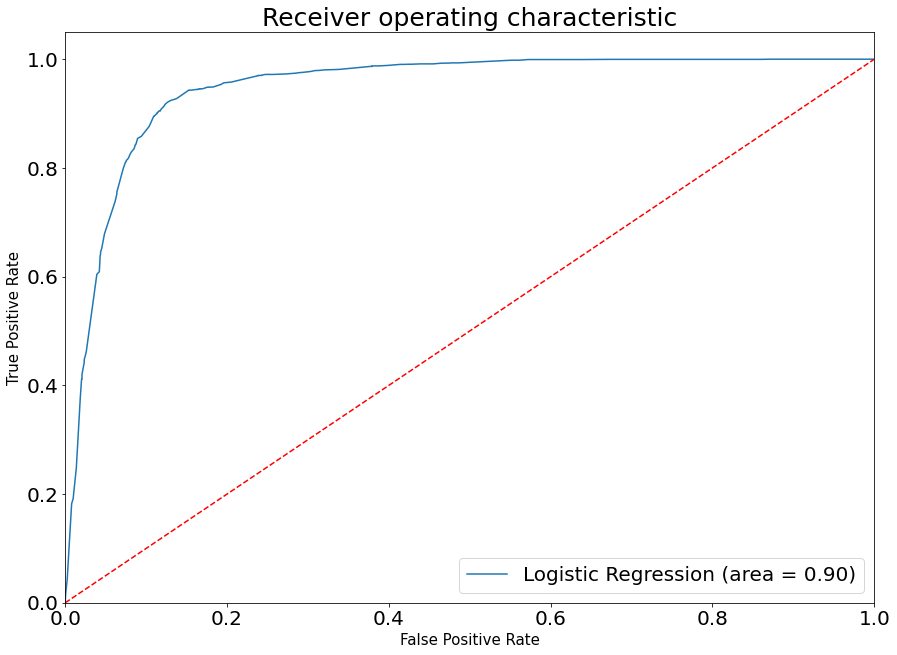

In [49]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate',fontsize = 15)
plt.title('Receiver operating characteristic', fontsize = 25)
plt.legend(loc="lower right")
plt.rc('font', size = 20)
fig = plt.gcf()
fig.set_size_inches(14.5, 10.5)
plt.show()